In [ ]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.2 MB/s eta 0:00:00


In [ ]:
pip install yacs

In [ ]:


# STEP 2: Setup HRNet Environment
%cd /content/drive/MyDrive/HRNet-Human-Pose-Estimation

import sys
sys.path.append('/content/drive/MyDrive/HRNet-Human-Pose-Estimation')
sys.path.append('/content/drive/MyDrive/HRNet-Human-Pose-Estimation/lib')

import torch
import cv2
import numpy as np
import os
from tqdm import tqdm
import pandas as pd

from lib.config import cfg
from lib.config import update_config
from lib.models.pose_hrnet import get_pose_net
from lib.core.inference import get_final_preds
from lib.utils.transforms import get_affine_transform

# STEP 3: Load HRNet config and model (CPU-only)
cfg_file = "experiments/coco/hrnet/w48_384x288_adam_lr1e-3.yaml"
import types
args = types.SimpleNamespace()
args.cfg = cfg_file
args.opts = []
args.modelDir = ''
args.logDir = ''
args.dataDir = ''
args.prevModelDir = ''
update_config(cfg, args)

# Load model weights to CPU
model = get_pose_net(cfg, is_train=False)
model.load_state_dict(torch.load("models/pytorch/pose_coco/pose_hrnet_w48_384x288.pth", map_location=torch.device('cpu')))
model = model.eval()

# Constants
IMG_SIZE = (384, 288)
ROOT_PATH = "/content/drive/MyDrive/Dataset"
VALID_EXT = [".png", ".jpg"]

# STEP 4: Image preprocessing for HRNet
def preprocess_image(img_path):
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if image is None:
        return None, None, None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    center = np.array([image.shape[1] // 2, image.shape[0] // 2])
    scale = np.array([image.shape[1], image.shape[0]]) / 200

    trans = get_affine_transform(center, scale, 0, IMG_SIZE)
    input_img = cv2.warpAffine(image, trans, IMG_SIZE, flags=cv2.INTER_LINEAR)
    input_img = input_img.astype(np.float32) / 255.0
    input_img = input_img.transpose(2, 0, 1)
    input_img = torch.from_numpy(input_img).unsqueeze(0).float()  # CPU
    return input_img, center, scale

# STEP 5: Inference for a single image
def infer_keypoints(img_path):
    input_tensor, center, scale = preprocess_image(img_path)
    if input_tensor is None:
        return None
    with torch.no_grad():
        output = model(input_tensor)
        preds, _ = get_final_preds(cfg, output.numpy(), np.array([center]), np.array([scale]))
    return preds[0].flatten().tolist()

# STEP 6: Run HRNet on all images in dataset
results = []
for subject in sorted(os.listdir(ROOT_PATH)):
    subject_path = os.path.join(ROOT_PATH, subject, "bg-01", "000")
    if not os.path.isdir(subject_path):
        continue

    for fname in sorted(os.listdir(subject_path)):
        if not any(fname.lower().endswith(ext) for ext in VALID_EXT):
            continue

        img_path = os.path.join(subject_path, fname)
        keypoints = infer_keypoints(img_path)
        if keypoints:
            results.append([f"{subject}/bg-01/000/{fname}"] + keypoints)

# STEP 7: Save pose keypoints to CSV
columns = ["image"] + [f"{i}_{c}" for i in range(17) for c in ['x', 'y']]
df = pd.DataFrame(results, columns=columns)
output_csv_path = "/content/drive/MyDrive/HRNet-Human-Pose-Estimation/tools/casia_pose_all_subjects.csv"
df.to_csv(output_csv_path, index=False)

print(f"✅ Pose keypoints saved to: {output_csv_path}")


/content/drive/MyDrive/HRNet-Human-Pose-Estimation
✅ Pose keypoints saved to: /content/drive/MyDrive/HRNet-Human-Pose-Estimation/tools/casia_pose_all_subjects.csv


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset

# === STEP 1: Load pose keypoints and convert to graphs ===
COCO_EDGES = [
    (0, 1), (0, 2), (1, 3), (2, 4),
    (5, 6), (5, 7), (7, 9), (6, 8), (8, 10),
    (5, 11), (6, 12), (11, 12), (11, 13), (13, 15),
    (12, 14), (14, 16)
]

def load_pose_graphs(csv_path):
    df = pd.read_csv(csv_path)
    graphs = []
    subject_ids = []

    for _, row in df.iterrows():
        subject_id = row['image'].split('/')[0]
        subject_ids.append(subject_id)

        keypoints = np.array([row[f"{i}_{c}"] for i in range(17) for c in ['x', 'y']]).reshape(17, 2)
        x = torch.tensor(keypoints, dtype=torch.float)
        edge_index = torch.tensor(COCO_EDGES, dtype=torch.long).t().contiguous()

        data = Data(x=x, edge_index=edge_index)
        graphs.append(data)

    return graphs, subject_ids

csv_path = "/content/drive/MyDrive/HRNet-Human-Pose-Estimation/tools/casia_pose_all_subjects.csv"
graphs, subject_ids = load_pose_graphs(csv_path)

# === STEP 2: Encode labels ===
label_encoder = LabelEncoder()
labels = torch.tensor(label_encoder.fit_transform(subject_ids), dtype=torch.long)
num_classes = len(label_encoder.classes_)

# === STEP 3: Dataset + Train/Val Split ===
class GaitGCNDataset(Dataset):
    def __init__(self, graphs, labels):
        self.graphs = graphs
        self.labels = labels

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        data = self.graphs[idx]
        data.y = self.labels[idx]
        return data

dataset = GaitGCNDataset(graphs, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# === STEP 4: Define GCN Model (with BatchNorm + Dropout) ===
class GCNModel(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, out_dim=128, num_classes=10):
        super(GCNModel, self).__init__()
        self.gcn1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, out_dim)
        self.bn2 = nn.BatchNorm1d(out_dim)
        self.classifier = nn.Sequential(
            nn.Linear(out_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, num_classes)
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.bn1(self.gcn1(x, edge_index)))
        x = F.relu(self.bn2(self.gcn2(x, edge_index)))
        x = global_mean_pool(x, batch)
        return self.classifier(x)

# === STEP 5: Train the model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCNModel(num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

def evaluate(loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            pred = out.argmax(dim=1)
            correct += (pred == batch.y).sum().item()
            total += batch.num_graphs
    return correct / total

# Training loop
for epoch in range(1, 31):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    val_acc = evaluate(val_loader)
    print(f"Epoch {epoch:02d}, Train Loss: {total_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 01, Train Loss: 24.6835, Val Acc: 0.1712
Epoch 02, Train Loss: 24.0335, Val Acc: 0.3153
Epoch 03, Train Loss: 23.4640, Val Acc: 0.3604
Epoch 04, Train Loss: 22.8373, Val Acc: 0.3874
Epoch 05, Train Loss: 22.4999, Val Acc: 0.4234
Epoch 06, Train Loss: 21.9924, Val Acc: 0.4414
Epoch 07, Train Loss: 21.8787, Val Acc: 0.3874
Epoch 08, Train Loss: 21.2710, Val Acc: 0.4414
Epoch 09, Train Loss: 21.2371, Val Acc: 0.4595
Epoch 10, Train Loss: 21.0051, Val Acc: 0.4685
Epoch 11, Train Loss: 20.8774, Val Acc: 0.4955
Epoch 12, Train Loss: 20.5107, Val Acc: 0.4865
Epoch 13, Train Loss: 20.2005, Val Acc: 0.4595
Epoch 14, Train Loss: 20.2041, Val Acc: 0.4775
Epoch 15, Train Loss: 19.9708, Val Acc: 0.4505
Epoch 16, Train Loss: 19.7114, Val Acc: 0.4505
Epoch 17, Train Loss: 19.3496, Val Acc: 0.4865
Epoch 18, Train Loss: 19.2138, Val Acc: 0.4505
Epoch 19, Train Loss: 19.1434, Val Acc: 0.5135
Epoch 20, Train Loss: 19.1689, Val Acc: 0.5045
Epoch 21, Train Loss: 18.9913, Val Acc: 0.4865
Epoch 22, Tra

In [ ]:
# ✅ Complete Early Fusion Training Script (CNN + GCN)

import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split
from torchvision import transforms
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as GeoDataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

# === Model Definitions ===
class CNNBranch(nn.Module):
    def __init__(self, out_dim=128):
        super(CNNBranch, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten()
        )
        self.fc = nn.Linear(64 * 32 * 32, out_dim)

    def forward(self, x):
        x = self.features(x)
        return self.fc(x)

class GCNBranch(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, out_dim=128):
        super(GCNBranch, self).__init__()
        self.gcn1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, out_dim)
        self.bn2 = nn.BatchNorm1d(out_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.bn1(self.gcn1(x, edge_index)))
        x = F.relu(self.bn2(self.gcn2(x, edge_index)))
        x = global_mean_pool(x, batch)
        return x

class EarlyFusionModel(nn.Module):
    def __init__(self, cnn_out=128, gcn_out=128, num_classes=10):
        super(EarlyFusionModel, self).__init__()
        self.cnn = CNNBranch(out_dim=cnn_out)
        self.gcn = GCNBranch(out_dim=gcn_out)
        self.classifier = nn.Sequential(
            nn.Linear(cnn_out + gcn_out, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, image, graph):
        cnn_feat = self.cnn(image)
        gcn_feat = self.gcn(graph)
        fused = torch.cat([cnn_feat, gcn_feat], dim=1)
        return self.classifier(fused)

# === Dataset Setup ===
class FusionDataset(Dataset):
    def __init__(self, root_dir, image_names, pose_graphs, label_map, transform=None):
        self.root_dir = root_dir
        self.image_names = image_names
        self.pose_graphs = pose_graphs
        self.label_map = label_map
        self.transform = transform or transforms.ToTensor()

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        rel_path = self.image_names[idx]
        full_path = os.path.join(self.root_dir, rel_path)
        image = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (128, 128))
        image = self.transform(image)
        graph = self.pose_graphs[idx]
        subject_id = rel_path.split('/')[0]
        label = torch.tensor(self.label_map[subject_id], dtype=torch.long)
        return image, graph, label

# === Data Preparation ===
pose_csv = "/content/drive/MyDrive/HRNet-Human-Pose-Estimation/tools/casia_pose_all_subjects.csv"
df = pd.read_csv(pose_csv)
image_names = df['image'].tolist()
keypoints = df.iloc[:, 1:].values.reshape(-1, 17, 2)

COCO_EDGES = [(0, 1), (0, 2), (1, 3), (2, 4), (5, 6), (5, 7), (7, 9), (6, 8), (8, 10),
              (5, 11), (6, 12), (11, 12), (11, 13), (13, 15), (12, 14), (14, 16)]
edge_index = torch.tensor(COCO_EDGES, dtype=torch.long).t().contiguous()
pose_graphs = [Data(x=torch.tensor(kpt, dtype=torch.float), edge_index=edge_index) for kpt in keypoints]

subject_ids = [img.split('/')[0] for img in image_names]
le = LabelEncoder()
encoded_labels = le.fit_transform(subject_ids)
label_map = {sid: lbl for sid, lbl in zip(subject_ids, encoded_labels)}

fusion_dataset = FusionDataset(
    root_dir="/content/drive/MyDrive/Dataset",
    image_names=image_names,
    pose_graphs=pose_graphs,
    label_map=label_map
)

train_size = int(0.8 * len(fusion_dataset))
val_size = len(fusion_dataset) - train_size
train_set, val_set = random_split(fusion_dataset, [train_size, val_size])
train_loader = GeoDataLoader(train_set, batch_size=16, shuffle=True)
val_loader = GeoDataLoader(val_set, batch_size=16)

# === Training ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fusion_model = EarlyFusionModel(num_classes=len(label_map)).to(device)
optimizer = torch.optim.Adam(fusion_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

def evaluate_accuracy(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for image, graph, label in loader:
            image, graph, label = image.to(device), graph.to(device), label.to(device)
            out = model(image, graph)
            pred = out.argmax(dim=1)
            correct += (pred == label).sum().item()
            total += len(label)
    acc = correct / total
    print(f"Validation Accuracy: {acc:.4f}")
    return acc

for epoch in range(1, 21):
    fusion_model.train()
    total_loss = 0
    for image, graph, label in train_loader:
        image, graph, label = image.to(device), graph.to(device), label.to(device)
        optimizer.zero_grad()
        out = fusion_model(image, graph)
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    val_acc = evaluate_accuracy(fusion_model, val_loader)
    print(f"Epoch {epoch:02d}, Loss: {total_loss:.4f}, Val Acc: {val_acc:.4f}")


Validation Accuracy: 0.7207
Epoch 01, Loss: 35.3284, Val Acc: 0.7207
Validation Accuracy: 0.9009
Epoch 02, Loss: 14.3466, Val Acc: 0.9009
Validation Accuracy: 0.9550
Epoch 03, Loss: 4.2833, Val Acc: 0.9550
Validation Accuracy: 0.9820
Epoch 04, Loss: 1.8872, Val Acc: 0.9820
Validation Accuracy: 0.9910
Epoch 05, Loss: 1.3252, Val Acc: 0.9910
Validation Accuracy: 0.9820
Epoch 06, Loss: 0.6441, Val Acc: 0.9820
Validation Accuracy: 0.9369
Epoch 07, Loss: 1.7423, Val Acc: 0.9369
Validation Accuracy: 0.9910
Epoch 08, Loss: 0.7592, Val Acc: 0.9910
Validation Accuracy: 0.9910
Epoch 09, Loss: 0.2629, Val Acc: 0.9910
Validation Accuracy: 0.9640
Epoch 10, Loss: 0.3271, Val Acc: 0.9640
Validation Accuracy: 0.9910
Epoch 11, Loss: 0.3119, Val Acc: 0.9910
Validation Accuracy: 0.9910
Epoch 12, Loss: 0.0489, Val Acc: 0.9910
Validation Accuracy: 0.9910
Epoch 13, Loss: 0.0303, Val Acc: 0.9910
Validation Accuracy: 0.9910
Epoch 14, Loss: 0.0285, Val Acc: 0.9910
Validation Accuracy: 0.9910
Epoch 15, Loss: 0.

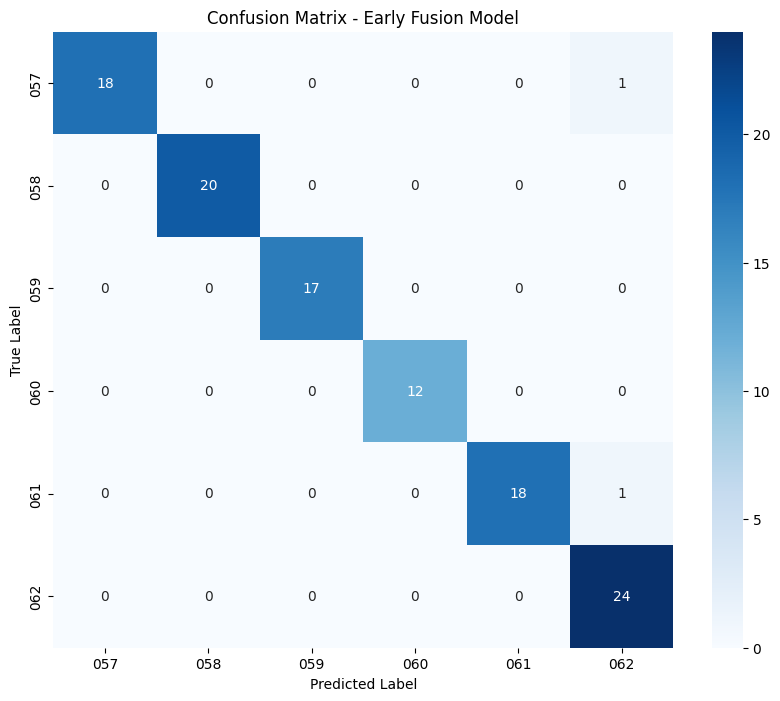

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Get predictions and true labels
def get_all_preds(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for image, graph, label in loader:
            image, graph = image.to(device), graph.to(device)
            out = model(image, graph)
            preds = out.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(label.numpy())
    return all_labels, all_preds

# Step 2: Compute confusion matrix
true_labels, pred_labels = get_all_preds(fusion_model, val_loader)
cm = confusion_matrix(true_labels, pred_labels)
class_names = list(label_map.values())  # numeric labels

# Optional: reverse label_map for readable labels
reverse_label_map = {v: k for k, v in label_map.items()}
class_names = [reverse_label_map[i] for i in range(len(reverse_label_map))]

# Step 3: Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Early Fusion Model")
plt.show()
